Tugas Besar Data Mining

Syamsul Rizal 130118xxxx

#Library

In [2]:
!pip install langdetect

     |████████████████████████████████| 981 kB 27.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=582decfd1c72c0a167f47a8c92f93febd2bcd60f5c5a67fe1175bf12711f6513
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from langdetect import detect, DetectorFactory
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, sigmoid_kernel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

#Eksplorasi Data

Data yang digunakan yaitu items.csv dan transaction.csv. Kedua data tersebut kemudian digabungkan dan ditambahkan kolom total basket untuk melihat dan mensortir dataset tersebut dengan asumsi buku tersebut harus pernah masuk kedalam basket

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import items.csv
data = pd.read_csv('drive/My Drive/Damin/items.csv', sep='|')
data.head()

,itemID,title,author,publisher,main topic,subtopics
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
2,19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]"
3,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]"
4,46107,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]"


In [ ]:
# Import transaction.csv
ts = pd.read_csv('drive/My Drive/Damin/transactions.csv', sep = '|')
ts.head()

,sessionID,itemID,click,basket,order
0,0,21310,1,0,0
1,1,73018,1,0,0
2,2,19194,1,0,0
3,3,40250,1,0,0
4,4,46107,1,0,0


In [ ]:
# Merge 2 dataset
df = pd.merge(data,ts,on = ['itemID'],how = 'left')

In [ ]:
# Membuat dan mensortir total basket
tmp = df.groupby('title')['basket'].count().reset_index()
tmp.rename(columns={'basket': 'total_basket'}, inplace = True)
df_new = df.merge(tmp, on='title')
df_new = df_new[df_new['total_basket'] >= 1]
df_new.drop_duplicates(['itemID','title'], inplace = True)

In [ ]:
#mereset index
df_new = df_new.reset_index()
df_new = df_new.drop(columns='index')

In [ ]:
df_new.sort_values(['total_basket'], ascending = False)

,itemID,title,author,publisher,main topic,subtopics,sessionID,click,basket,order,total_basket
250,58522,Harry Potter Box Set: The Complete Collection ...,Joanne K. Rowling,Bloomsbury UK,YFH,[YFB],184.0,1.0,0.0,0.0,2291
29,24211,Der Herr der Ringe,J. R. R. Tolkien,Klett-Cotta Verlag,FYT,"[FMB,FYT]",9290.0,2.0,0.0,0.0,2066
26,45332,Der Herr der Ringe,John Ronald Reuel Tolkien,Klett-Cotta Verlag,FMB,"[FB,FYT,YFH]",449.0,1.0,0.0,0.0,2066
27,77619,Der Herr der Ringe,John R Tolkien,Klett-Cotta Verlag,FMB,"[FYT,YFH]",718.0,1.0,0.0,0.0,2066
28,14442,Der Herr der Ringe,J.R.R. Tolkien,Klett-Cotta Verlag,FMB,[FYT],1230.0,1.0,0.0,0.0,2066
...,...,...,...,...,...,...,...,...,...,...,...
15951,28542,SISTER KINGDOM,Ifesinachi Nelson Ezeh,Xlibris,FMH,[],63039.0,1.0,0.0,0.0,1
15952,59114,2120 A. D. Neuland,Harald Kaup,NOEL-Verlag,FLC,[FLS],63046.0,1.0,0.0,0.0,1
21269,23410,Heretics Anonymous,Katie Henry,Harper Collins Publ. USA,QRYA5,"[YFM,YFQ,YXZR]",135005.0,1.0,1.0,0.0,1
12199,63424,The Making of a Saint,Maugham W. Somerset,Book on Demand Ltd.,FMB,[],34054.0,1.0,0.0,0.0,1


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26870 entries, 0 to 26869
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   itemID        26870 non-null  int64  
 1   title         26870 non-null  object 
 2   author        24825 non-null  object 
 3   publisher     26869 non-null  object 
 4   main topic    26735 non-null  object 
 5   subtopics     26870 non-null  object 
 6   sessionID     24909 non-null  float64
 7   click         24909 non-null  float64
 8   basket        24909 non-null  float64
 9   order         24909 non-null  float64
 10  total_basket  26870 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 2.3+ MB


# Pre Processing

## Detect Language

Tahap ini dilakukan untuk mendeteksi bahasa suatu buku dengan melihat judul buku yang ada

In [ ]:
#function untuk mendeteksi bahasa
DetectorFactory.seed = 0
def detectlang(text):
  try:
    tmp = detect(text)
  except:
    tmp = 'other'
  return tmp

In [ ]:
#menimplementasikan function diatas dan di input kedalam kolom 'lang'
df_new['lang'] = df_new['title'].apply(lambda x: detectlang(x))

In [ ]:
df_new.head()

,itemID,title,author,publisher,main topic,subtopics,sessionID,click,basket,order,total_basket,lang
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],0.0,1.0,0.0,0.0,3,en
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",1.0,1.0,0.0,0.0,59,de
2,19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]",2.0,1.0,0.0,0.0,204,en
3,1878,Red Queen 1,Victoria Aveyard,Harper Collins Publ. USA,YFCB,"[5AP,YFE,YFH]",2446.0,3.0,0.0,0.0,204,en
4,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]",3.0,1.0,0.0,0.0,339,de


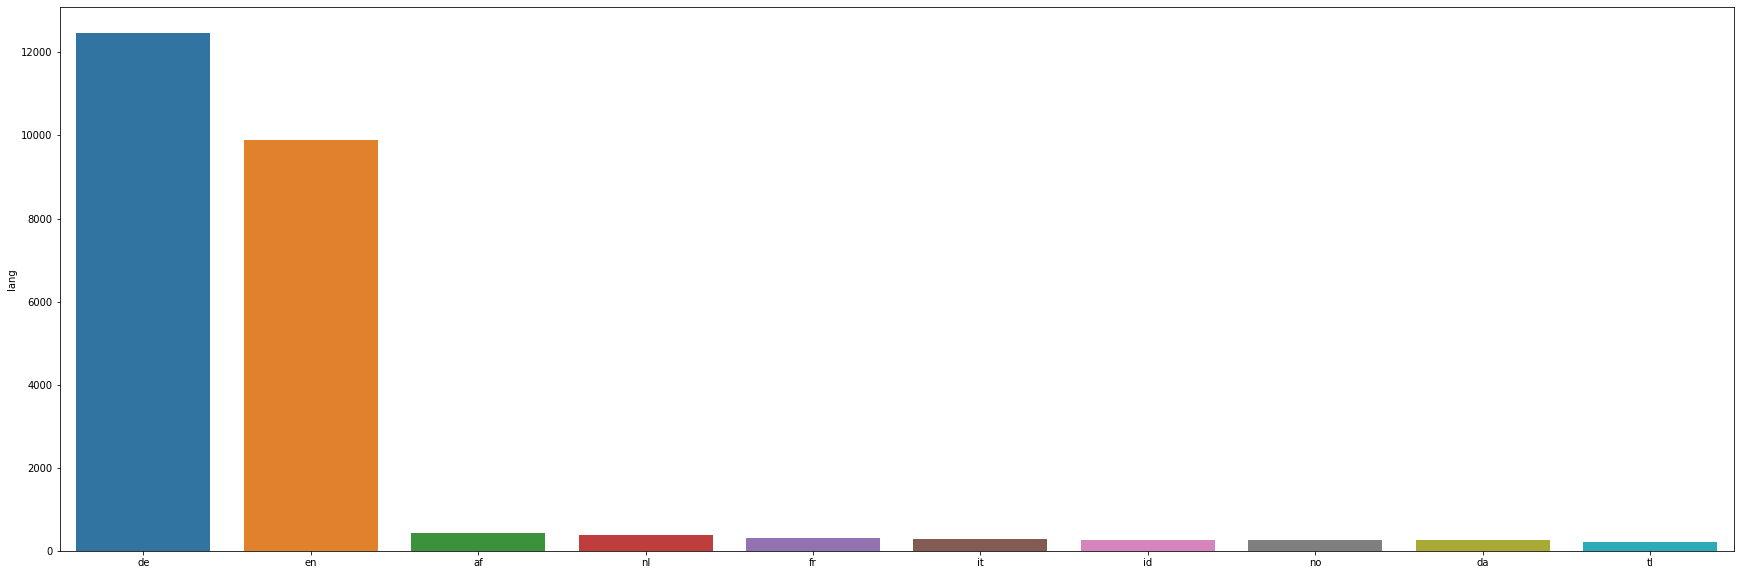

In [ ]:
#sebaran data['lang']
plt.figure(figsize=(30,10))
ax = sns.barplot(x=df_new['lang'].value_counts()[:10].index, y=df_new.lang.value_counts()[:10])

## Feature Selection

Memilih Fitur/Kolom yang akan digunakan dalam modeling nanti. kolom yang digunakan yaitu title,main topic, lang, total basket

In [ ]:
# Pemisahan data ke dalam df baru
df_select = df_new[['title','main topic','lang','total_basket']]
df_select.head()

,title,main topic,lang,total_basket
0,Princess Poppy: The Big Mix Up,YFB,en,3
1,Einfach zeichnen! Step by Step,AGZ,de,59
2,Red Queen 1,YFH,en,204
3,Red Queen 1,YFCB,en,204
4,Meine Kindergarten-Freunde (Pirat),YB,de,339


In [ ]:
# Merubah isi main topic menjadi 2 Char saja untuk memaksimalkan hasil clustering
df_select['main topic'] = df_select['main topic'].astype(str).str[0:2]
df_select.head()

,title,main topic,lang,total_basket
0,Princess Poppy: The Big Mix Up,YF,en,3
1,Einfach zeichnen! Step by Step,AG,de,59
2,Red Queen 1,YF,en,204
3,Red Queen 1,YF,en,204
4,Meine Kindergarten-Freunde (Pirat),YB,de,339


## Label Encoding

Merubah seluruh isi data yang ada menjadi nilai numerik dengan menggunakan library LabelEncoding. Hal ini dilakukan untuk mempermudah proses clustering

In [ ]:
# Merubah type data menjadi numeric
col_categoric = []
type_num = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
col = df_select.columns.values.tolist()

for col in col:
  if df_select[col].dtype in type_num:
    continue

  col_categoric.append(col)

for col in col_categoric:
  if col in df_select.columns:
    end = LabelEncoder()
    end.fit(list(df_select[col].astype(str).values))
    df_select[col] = end.transform(list(df_select[col].astype(str).values))

In [ ]:
df_select.head()

,title,main topic,lang,total_basket
0,15448,89,6,3
1,7105,3,5,59
2,15806,89,6,204
3,15806,89,6,204
4,13395,87,5,339


In [ ]:
df_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26870 entries, 0 to 26869
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   title         26870 non-null  int64
 1   main topic    26870 non-null  int64
 2   lang          26870 non-null  int64
 3   total_basket  26870 non-null  int64
dtypes: int64(4)
memory usage: 839.8 KB


## Scalling

Scaling yang digunakan yaitu StandarcScaler. Scaler tersebut dipilih agar sebaran datanya tidak bervariasi namun tidak terlalu jauh persebarannya

In [ ]:
# Implementasi Scaler
scale = StandardScaler()
df_scale = pd.DataFrame(scale.fit_transform(df_select), columns= df_select.columns)

In [ ]:
df_scale.head()

,title,main topic,lang,total_basket
0,0.534655,0.901467,-0.180285,-0.217812
1,-0.686904,-1.737335,-0.379081,0.636024
2,0.587072,0.901467,-0.180285,2.846848
3,0.587072,0.901467,-0.180285,2.846848
4,0.234060,0.840100,-0.379081,4.905202


In [ ]:
# Export dataset
df_scale.to_csv('drive/My Drive/Damin/items_preprocess.csv')

#Clustering

Teknik yang digunakan untuk model ini yaitu Clustering. Hal tersebut dipilih karena Clustering dapat melihat data yang sama dengan lebih mudah. Metode yang digunakan yaitu Kmeans dengan asumsi clusternya sebanyak 20 

In [ ]:
# Membuat Model
model = KMeans(n_clusters = 20)
model.fit(df_scale)

KMeans(n_clusters=20)

In [ ]:
# Menambahkan nilai cluster kedalam dataframe yang dipakai
df_new['cluster'] = model.labels_
df_scale['cluster'] = model.labels_

In [ ]:
df_new.head()

,itemID,title,author,publisher,main topic,subtopics,sessionID,click,basket,order,total_basket,lang,cluster
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],0.0,1.0,0.0,0.0,3,en,0
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",1.0,1.0,0.0,0.0,59,de,7
2,19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]",2.0,1.0,0.0,0.0,204,en,18
3,1878,Red Queen 1,Victoria Aveyard,Harper Collins Publ. USA,YFCB,"[5AP,YFE,YFH]",2446.0,3.0,0.0,0.0,204,en,18
4,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]",3.0,1.0,0.0,0.0,339,de,17


In [ ]:
# Export dataset
df_new.to_csv('drive/My Drive/Damin/items_final.csv')

In [ ]:
df_scale.head()

,title,main topic,lang,total_basket,cluster
0,0.534655,0.901467,-0.180285,-0.217812,0
1,-0.686904,-1.737335,-0.379081,0.636024,7
2,0.587072,0.901467,-0.180285,2.846848,18
3,0.587072,0.901467,-0.180285,2.846848,18
4,0.234060,0.840100,-0.379081,4.905202,17


In [ ]:
# Export dataset
df_scale.to_csv('drive/My Drive/Damin/items_preprocess_final.csv')

#Evaluation

Pada tahap evaluasi kali ini terdapat dataset evaluation.csv untuk diberikan rekomendasi berdasarkan itemID yang ada. itemID yang terdapat pada csv tersebut kemudian diberi 5 rekomendasi buku berdasarkan nilai sigmoid dan cluster yang ada. 

In [5]:
# Import data evaluation.csv, hanya menggunakan 5 data pertama karena keterbatasan hardware komputer
df_eval = pd.read_csv('drive/My Drive/Damin/evaluation.csv')
df_eval = df_eval.iloc[:5]
df_eval

,itemID
0,12
1,45274
2,10104
3,41371
4,14015


In [ ]:
# Function untuk mencari rekomendasi berdasarkan itemID dan nilai sigmoid yang ada
def select_rec(itemid, sigmoid, df):
  i = indices[itemid]

  nilai_sigmoid = list(enumerate(sigmoid[i]))
  nilai_sigmoid = sorted(nilai_sigmoid, key=lambda x: x[1], reverse=True)
  nilai_sigmoid = nilai_sigmoid[1:6]

  idx_book = [i[0] for i in nilai_sigmoid]

  return df['itemID'].iloc[idx_book]

In [ ]:
# Main Program Evaluation
i = 0
rec_1 = []
rec_2 = []
rec_3 = []
rec_4 = []
rec_5 = []
dt = df_scale

start = time()
while i < len(df_eval):
  df_temp = df_new.loc[df_new['itemID'] == df_eval['itemID'][i]]
  
  #Jika data pada evaluation.csv tidak ada pada items.csv sistem akan memberikan 5 rekomendasi buku yang random
  if df_temp.empty:
    rand1 = df_new['itemID'].sample().tolist()[0]
    rec_1.append(rand1)
    rand2 = df_new['itemID'].sample().tolist()[0]
    rec_2.append(rand2)
    rand3 = df_new['itemID'].sample().tolist()[0] 
    rec_3.append(rand3)
    rand4 = df_new['itemID'].sample().tolist()[0]
    rec_4.append(rand4)
    rand5 = df_new['itemID'].sample().tolist()[0]
    rec_5.append(rand5)
    
  #Jika data pada evaluation.csv ada pada items.csv sistem akan memberikan 5 rekomendasi buku yang ada berdasarkan cluster
  else:
    nilai_cluster = df_temp['cluster'].tolist()[0]

    tmp = None
    tmp = df_new.loc[df_new['cluster'] == nilai_cluster]
    tmp.reset_index(drop=True, inplace=True)

    sigmoid = None
    sigmoid = sigmoid_kernel(dt)
    indices = pd.Series(tmp.index, index=tmp['itemID']).drop_duplicates()
    rec_list = select_rec(df_eval['itemID'][i], sigmoid, tmp).tolist()

    rec_1.append(rec_list[0])
    rec_2.append(rec_list[1])
    rec_3.append(rec_list[2])
    rec_4.append(rec_list[3])
    rec_5.append(rec_list[4])

  print('iterasi ke-{}'.format(i + 1))
  i = i + 1

print('Waktu untuk mencari rekomendasi buku : {} detik'.format(round((time() - start), 2)))

iterasi ke-1
iterasi ke-2
iterasi ke-3
iterasi ke-4
iterasi ke-5
Waktu untuk mencari rekomendasi buku : 26.07 detik


In [ ]:
# Input hasil running kedalam df_eval
df_eval['rec_1'] = rec_1
df_eval['rec_2'] = rec_2
df_eval['rec_3'] = rec_3
df_eval['rec_4'] = rec_4
df_eval['rec_5'] = rec_5

In [ ]:
df_eval

,itemID,rec_1,rec_2,rec_3,rec_4,rec_5
0,12,76354,51983,64423,62284,58193
1,45274,47326,25268,64514,69024,71445
2,10104,10646,75834,32247,62002,989
3,41371,4283,52878,25809,19898,61686
4,14015,61673,32682,55696,42873,68855


In [ ]:
# Export dataset evaluation
df_eval.to_csv('drive/My Drive/Damin/evaluation_final.csv')

#Kesimpulan

Pada tahap ini saya mencoba melihat rekomendasi yang diberikan sistem. Saya memilih itemID pada index ke 4 pada evaluation.csv yaitu itemID = 41371

In [ ]:
res = df_new.loc[df_new['itemID'] == 41371]

dat1 = df_new.loc[df_new['itemID'] == 4283]
res = res.append(dat1,ignore_index=True)

dat2 = df_new.loc[df_new['itemID'] == 52878]
res = res.append(dat2,ignore_index=True)

dat3 = df_new.loc[df_new['itemID'] == 25809]
res = res.append(dat3,ignore_index=True)

dat4 = df_new.loc[df_new['itemID'] == 19898]
res = res.append(dat4,ignore_index=True)

dat5 = df_new.loc[df_new['itemID'] == 61686]
res = res.append(dat5,ignore_index=True)

In [ ]:
res

,itemID,title,author,publisher,main topic,subtopics,sessionID,click,basket,order,total_basket,lang,cluster
0,41371,Dryadenhain & Dschinnenzauber (Märchenanthologie),"Philipp Busch, Jonathan Driedger, Lena Kalupne...",Ulisses Spiel & Medien,FM,"[FMB,WDHW]",138327.0,1.0,0.0,0.0,4,de,7
1,4283,Hold Me Tonight (Crushed-Trust-Reihe 2),Lana Rotaru,Carlsen Verlag GmbH,FRD,"[5AQ,5AX,5JA,5LKE,1KBB,FRM,YFM]",20.0,1.0,0.0,0.0,17,en,7
2,52878,Gaspard de la Nuit,Aloysius Bertrand,Hollywood Comics,FM,[],39.0,1.0,0.0,0.0,5,es,7
3,25809,Enceladus - Die Rückkehr,Brandon Q. Morris,Belle Epoque Verlag,FLP,"[1ZMCK,FLU]",107.0,2.0,1.0,0.0,18,de,7
4,19898,Jupiter,Brandon Q. Morris,Belle Epoque Verlag,FLP,"[5AT,1ZMCK,FLU]",107.0,1.0,1.0,0.0,10,en,7
5,61686,Gamechanger,L. X. Beckett,St Martin's Press,FL,[],114.0,1.0,0.0,0.0,4,de,7


Berdasarkan hasil data diatas dapat terlihat bahwa seluruh data memiliki main topic pertama yaitu F. berdasarkan https://ns.editeur.org/thema/en/F code F merupakan buku fiksi. lalu terdapat beberapa kesamaan bahasa buku yaitu de atau bahasa german. dan seluruh buku yang di rekomendasikan pernah masuk kedalam basket sehingga seseorang pernah tertarik pada buku tersebut.